In [ ]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cv2

from google.colab import drive

!pip install pytesseract
!sudo apt install tesseract-ocr
import pytesseract
import cv2
from matplotlib import colors, pyplot as plt
%matplotlib inline
import os

drive.mount('/content/drive')

path = '/content/drive/MyDrive/MIFI_imgs'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns

In [ ]:
# Получаем список изображений
img_list = os.listdir(path)
len_img = len(img_list) 

# Создаём id, относительный путь
images_paths = {i: img_list[i] for i in range(len_img)}

In [ ]:
# Получение рандомного изображения
def give_img():
  index = np.random.randint(0, len_img)
  img = molecules[index]

  return img, index

# Получение случайного изображения
def get_hard_img():

  index = np.random.randint(0, len(hard_images_list))
  img, id = hard_images_list[index]

  return img, id

In [ ]:
# ОБРАЗАНИЕ по картинке и таблице
def cut_info(img):
  sp = img.shape
  x, y = sp[0], sp[1]
  k = round(0.8916083916083916*x)
  info = img[k: x, 0:y]
  img = img[0:k, 0:y]
  # plt.imshow(info)
  return img, info


# Разделение на массивы ключ - id значение - np.array изображения
# molecules - картинок  {id: np.array}
# bricks - таблиц {id: np.array}

def do_data_split(path, images_paths, len_img):
  bricks = {}
  molecules = {}

  for i in range(len_img):
    image_path = f'{path}/{images_paths[i]}'
    img = cv2.imread(image_path)
    mol, brick = cut_info(img)

    molecules[i] = mol
    bricks[i] = brick

  return molecules, bricks

molecules, bricks = do_data_split(path, images_paths, len_img)

hard_images_list = []
for id, img in molecules.items():
  x = img.shape[0]
  
  # 8160 т.к. оно обрезанное
  if x == 8160:
    hard_images_list.append([img, id])



In [ ]:
def preprocessing(img):
    """Предобработка изображения. Медианный фильтр для отсечения шума,
    Эквализация для лучшего выделения частиц от фона."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # медианный фильтр
    img = cv2.medianBlur(img, 15)

    # эквализация
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
    # img = clahe.apply(img)

    return img

In [ ]:
# Выделение маски и контуров

def find_contours(img: np.array, level1=0, level2=255):
  ret, thresh = cv2.threshold(img, level1, level2, cv2.THRESH_OTSU)
  thresh = thresh.astype('uint8')
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
  return contours


def fing_conters_x2(img):
  contours_light = find_contours(img, 190, 255)
  counters_grey = find_contours(img, 90, 190)
  return contours_light, counters_grey


In [ ]:
# Наложение маски
def find_mask(contours):
  mask = np.zeros_like(img)

  for contour in contours:
      cv2.drawContours(mask, [contour], -1, (2**16, 2**16, 2**16), -1)

  return mask

In [ ]:
# Считываем размерность
def count_zoom(id):
  y=70
  x=0
  h=88
  w=2048


  image_path = f'{path}/{images_paths[id]}'
  img = cv2.imread(image_path)
  img = cv2.resize(img, (2048,2048))
  mol, brick = cut_info(img)

  brick = brick[y:y+h, x:x+w]
  th, brick = cv2.threshold(src=brick, thresh=220, maxval=255, type=cv2.THRESH_BINARY_INV)
  text_in_img = pytesseract.image_to_string(brick,  lang='eng', config=' tessedit_char_whitelist=0123456789')
  text = text_in_img[text_in_img.find('View field: ')+12:text_in_img.find(' Det:')]
  
  if ('mm') not in text:
    r = text[:text.find('um')-1]
    res = float(r)
  else:
    r = text[:text.find('mm')-1]
    res = float(r) * 1000

  result =  res / brick.shape[1]
  return result

In [ ]:
result

NameError: ignored

In [ ]:
# Считаем размеры мАлЕКУл

def square_dust(countours, index):
    result = []
    for contour in contours:
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [contour], -1, (2**16, 2**16, 2**16), -1)
        count = np.count_nonzero(mask)
        size = count * index
        if size >= 2.7:
            result.append(size)
    return result

In [ ]:
def information(arr):
  avg = np.mean(arr)
  # m = np.moda(arr)
  maxim = np.max(arr)
  minim = np.min(arr)

  return avg, maxim, minim
                 

# Давайте опробуем!

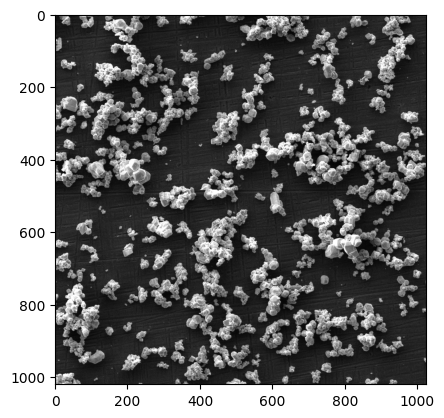

In [ ]:
# Возьмём любое случайное изображение

img, id = give_img()
plt.imshow(img)

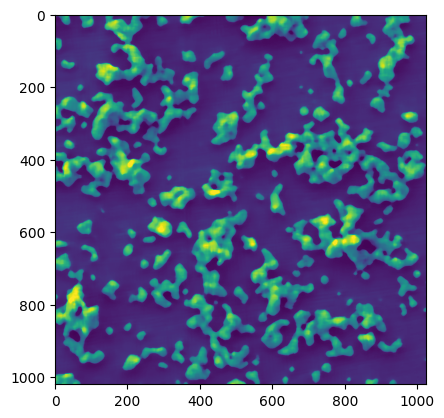

In [ ]:
# Предобрабатываем изображение
img = preprocessing(img)

plt.imshow(img)

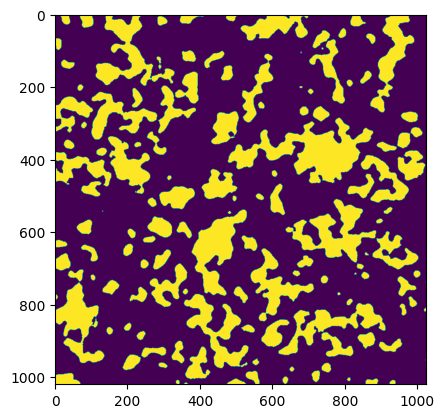

In [ ]:
# Выделяем контуры и создаём маску

contours = find_contours(img)
mask = find_mask(contours)

plt.imshow(mask)

In [ ]:
coef

0.9765625

In [ ]:
# Считаем размер ViewField

coef = count_zoom(id)
molecules_sizes = square_dust(contours, coef)



avg, maxim, minim = information(molecules_sizes)

СРЕДНЕЕ: 301.28977105850566
МАКСИМУМ: 3937.10595703125
МИНИМУМ: 2.705078125


<Axes: ylabel='Count'>

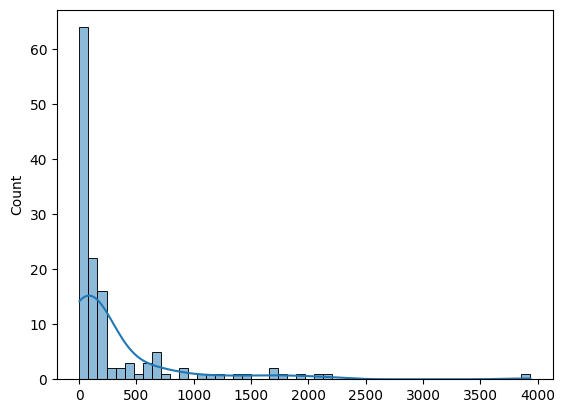

In [ ]:
print(f'СРЕДНЕЕ: {avg}\nМАКСИМУМ: {maxim}\nМИНИМУМ: {minim}')

sns.histplot(molecules_sizes, bins=50, kde=True)

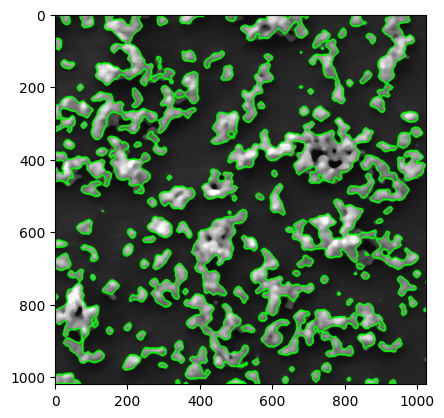

In [ ]:
image_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

cv2.drawContours(image_BGR, contours, -1, (0, 255, 0), 3)
plt.imshow(image_BGR)

## Посмотрим на самую большую молекуЛу

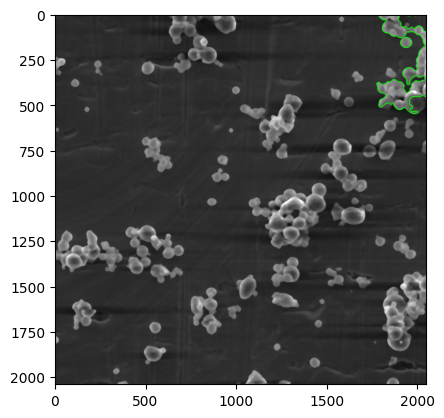

In [ ]:
image_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

cv2.drawContours(image_BGR, [max(contours, key=len)], -1, (0, 255, 0), 3)
plt.imshow(image_BGR)

# Теперь посмотрим на БОЛЬШИЕ изобрежаения

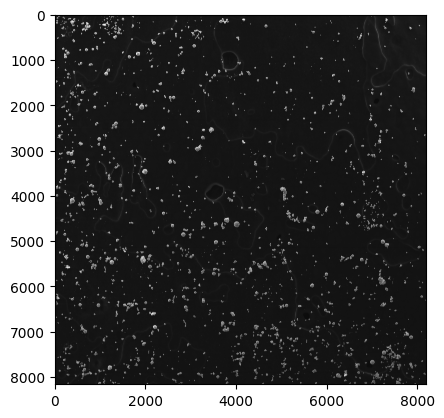

In [ ]:
img, id = get_hard_img()
plt.imshow(img)

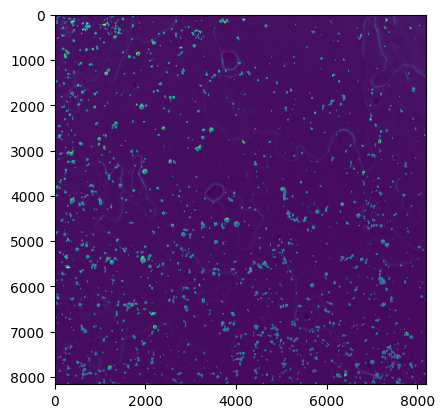

In [ ]:
# Предобрабатываем изображение
img = preprocessing(img)

plt.imshow(img)

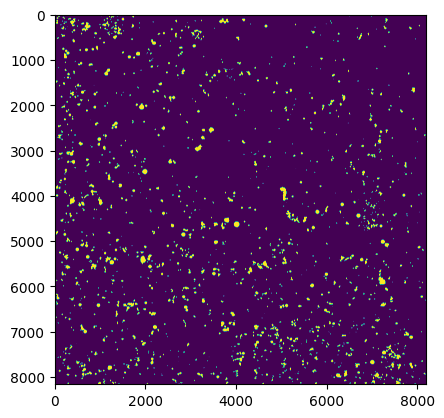

In [ ]:
# Выделяем контуры и создаём маску

contours = find_contours(img)
mask = find_mask(contours)

plt.imshow(mask)

In [ ]:
# Считаем размер ViewField

coef = count_zoom(id)
molecules_sizes = square_dust(contours, coef)



avg, maxim, minim = information(molecules_sizes)

In [ ]:
coef

0.9765625

СРЕДНЕЕ: 1764.4684163701068
МАКСИМУМ: 24030.2734375
МИНИМУМ: 3.90625


<Axes: ylabel='Count'>

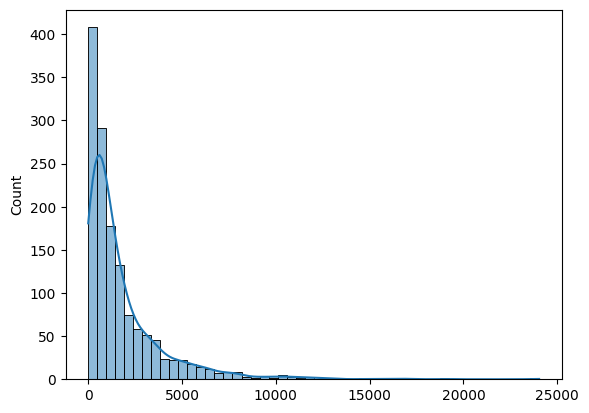

In [ ]:
print(f'СРЕДНЕЕ: {avg}\nМАКСИМУМ: {maxim}\nМИНИМУМ: {minim}')

sns.histplot(molecules_sizes, bins=50, kde=True)

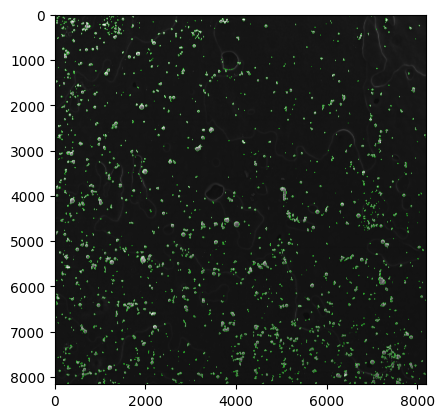

In [ ]:
image_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

cv2.drawContours(image_BGR, contours, -1, (0, 255, 0), 3)
plt.imshow(image_BGR)

### Самая большая молекула

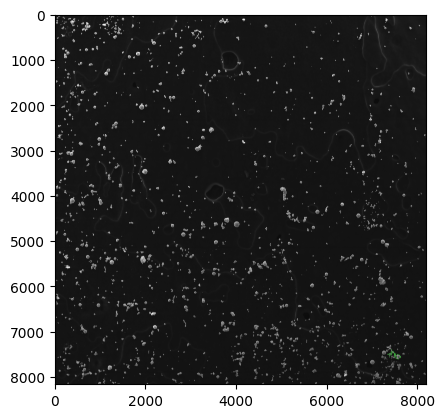

In [ ]:
image_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

cv2.drawContours(image_BGR, [max(contours, key=len)], -1, (0, 255, 0), 3)
plt.imshow(image_BGR)

Спасибо за задачу, было интересно е`` решать!

Авторы:

Ольшин Антон Михайлович:  olsh.ant@yandex.ru<br>
Трухин Григорий Адреввич: grigoriy.trukhin@bk.ru<br>
Проворова Анастасия Андреевна: enisejskaya@gmail.com